In [22]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
from sklearn import decomposition

import random
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


import seaborn as sns

In [3]:
# Globals
_SEED = 0

In [4]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [5]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [6]:
# filter labels
def filter_by_age(df, fromAge, toAge):
    return df[(df.age >= fromAge) & (df.age <=toAge)]

In [9]:
filtered_labels = filter_by_age(labels, 15, 25)

In [10]:
filtered_labels

,age,gender,race
620,15,0,0
621,15,0,0
622,15,0,0
623,15,0,0
624,15,0,0
...,...,...,...
5724,25,1,4
5725,25,1,4
5726,25,1,4
5727,25,1,4


In [11]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [12]:
X = np.empty((len(filtered_labels), h*w))

for i, index in enumerate(filtered_labels.index):
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

Done loading images


In [32]:
n, p = np.shape(X)

In [13]:
X

array([[ 31.,  27.,  24., ...,  43.,  44.,  45.],
       [ 37.,  34.,  29., ..., 180., 180., 180.],
       [114.,  45.,  15., ..., 221., 221., 221.],
       ...,
       [186., 186., 187., ..., 191., 205., 216.],
       [ 13.,  12.,  11., ..., 195., 196., 198.],
       [ 10.,  10.,  10., ..., 221., 221., 221.]])

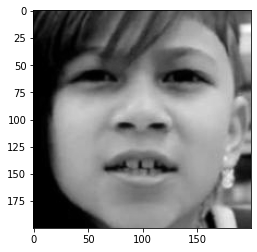

In [14]:
plt.imshow((X[0,:]).reshape(h,w), cmap='gray')

### Split dataset

In [15]:
y = filtered_labels[["age"]].to_numpy()

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
# Prepare for NMF - Make sure X is non-negative
# minX = np.min(np.min(Xtrain))
# Xtrain=Xtrain-minX
# Xtest=Xtest-minX;

In [17]:
k = 5 # number of nearest neighbours
lbda = .1 # L1 regularization used for SC and NSC

## NMF

In [38]:
left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 499)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

In [30]:
# Create model init method is set to random
n_components = 49
knn = KNeighborsClassifier(n_neighbors=k)
SST = np.sum(np.sum(Xtrain**2))
n_rows = 7 #for plotting
n_cols = 7 #for plotting

In [24]:
model = decomposition.NMF(n_components=n_components, init='random', random_state=0)
X_train_transformed = model.fit_transform(Xtrain)
L = 0.5*model.reconstruction_err_**2
components = model.components_

knn.fit(X_train_transformed,ytrain)
acc = knn.score(model.transform(Xtest),ytest)
X_test_hat = model.transform(Xtest).dot(model.components_)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


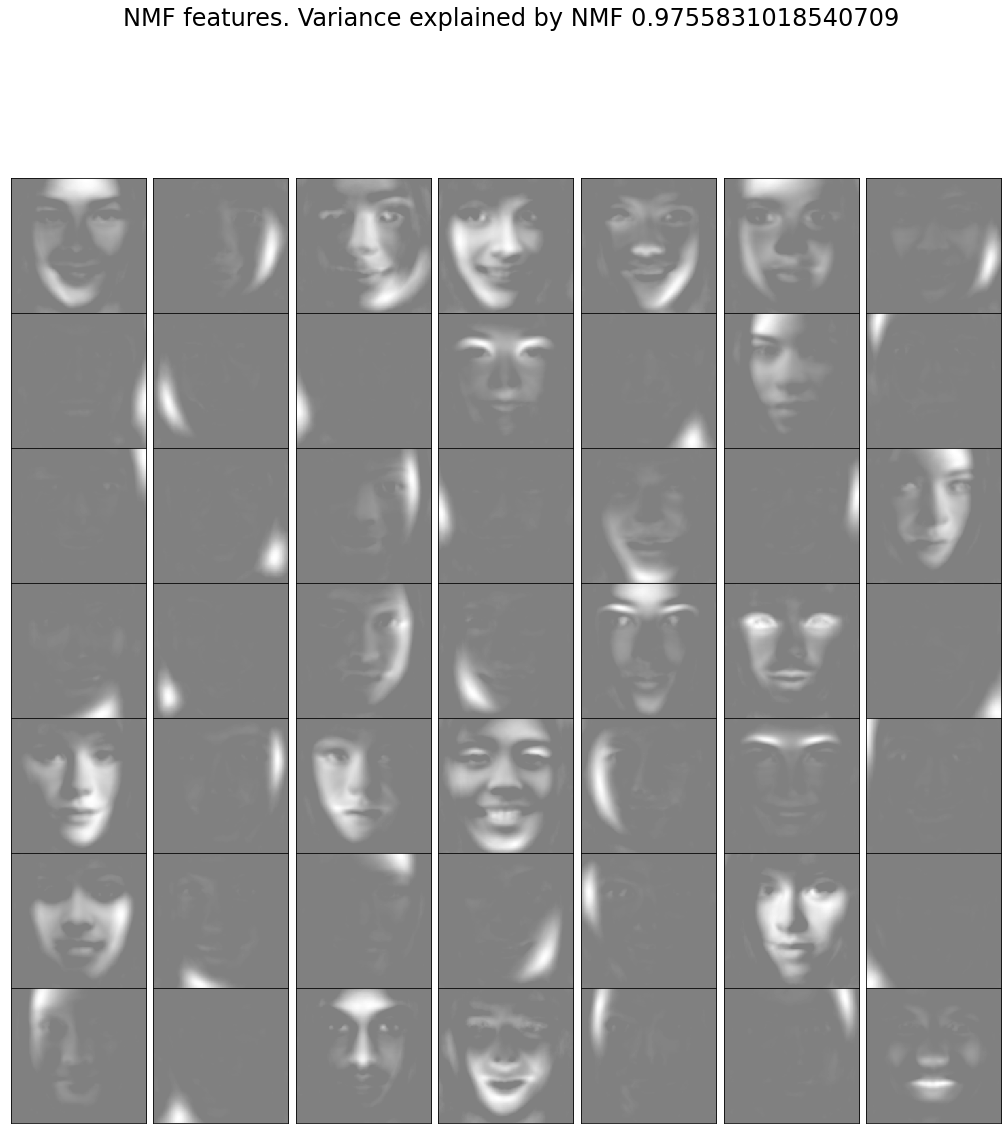

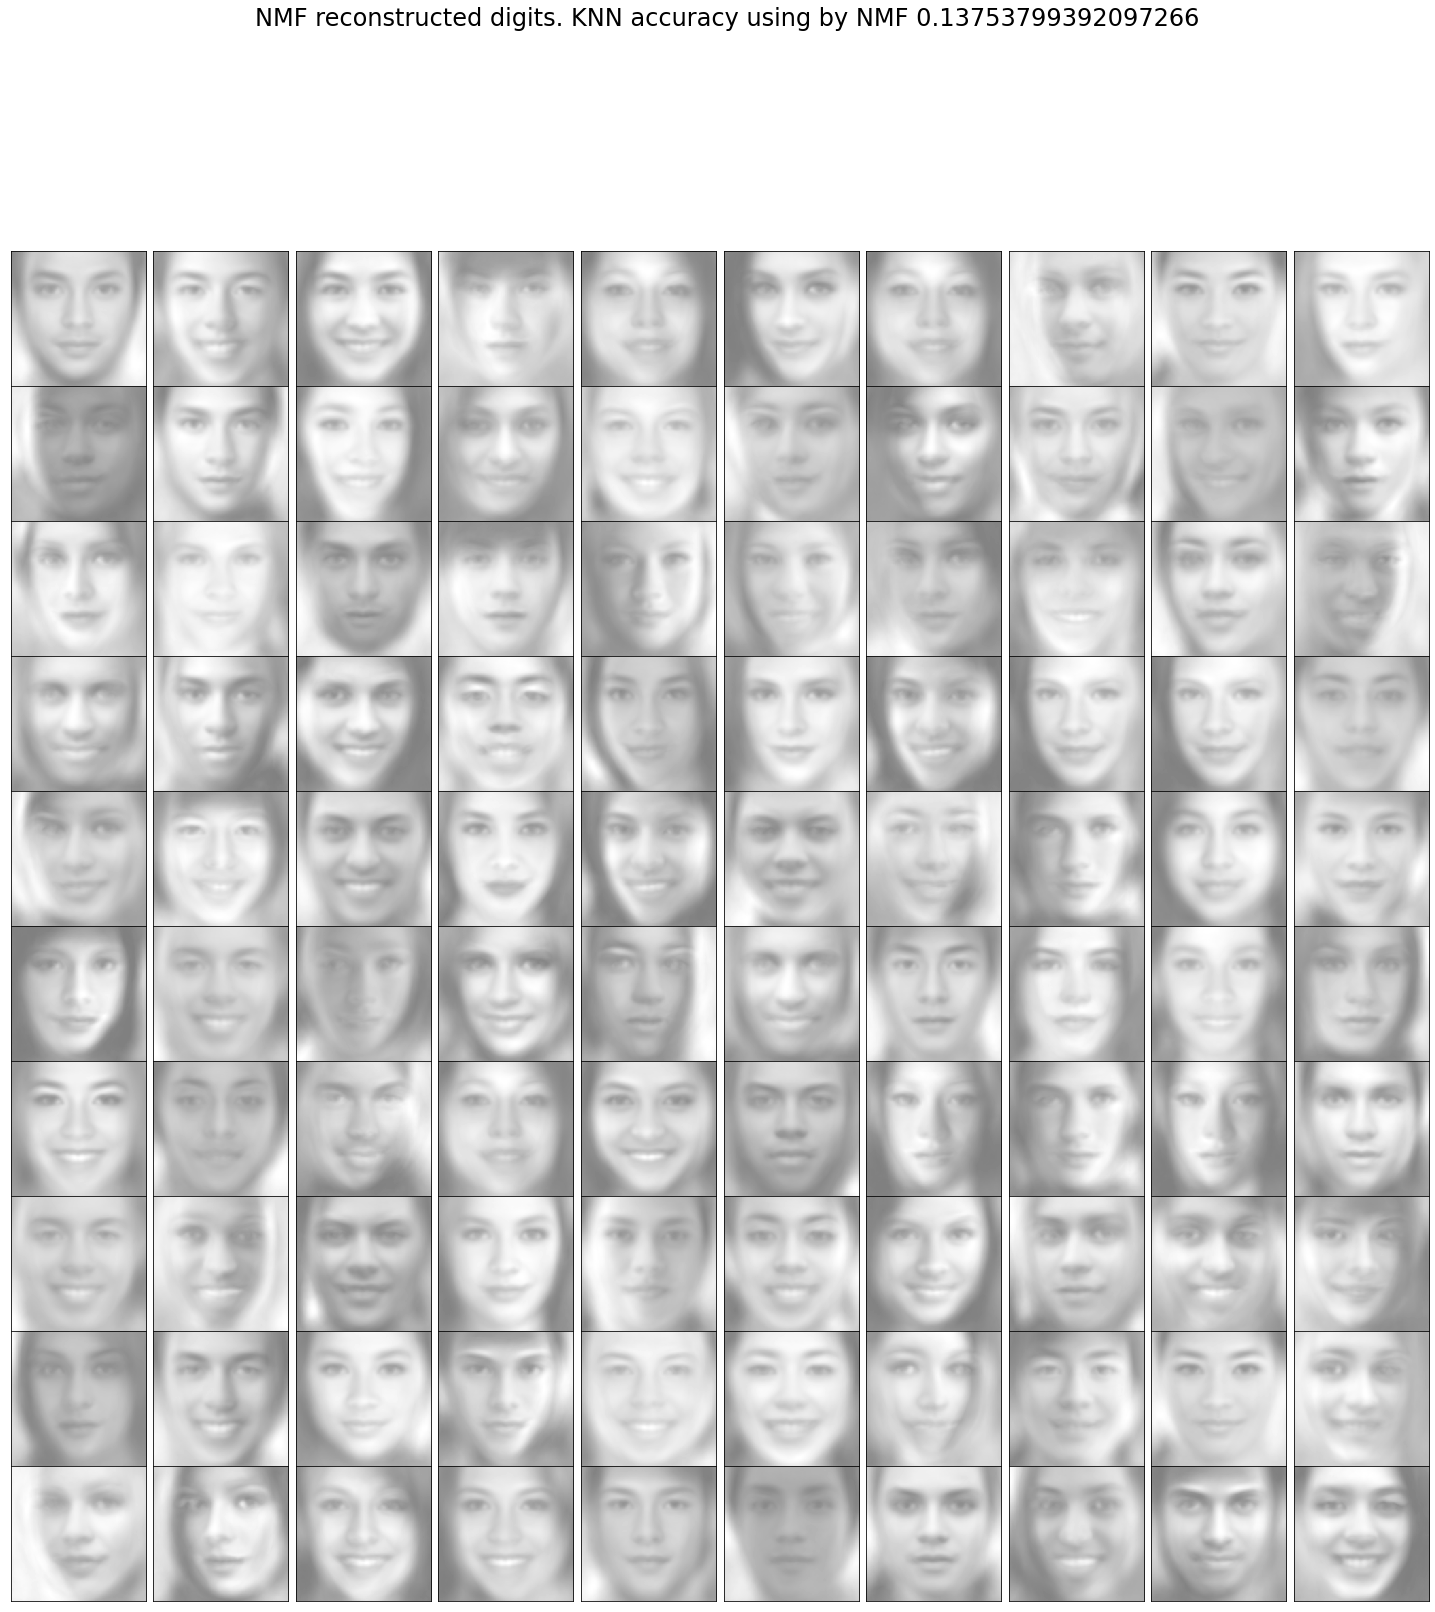

In [39]:
plot_components(f'NMF features. Variance explained by NMF {1-2*L/SST}', components)
plot_recons(X_test_hat, f'NMF reconstructed digits. KNN accuracy using by NMF {acc}')